In [1]:
import numpy as np
import tensorflow
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import os
os.listdir("/kaggle/input/coffee/Coffee Unzipped")

['Miner', 'Leaf rust', 'Cerscospora', 'Phoma', 'Healthy']

In [3]:
EPOCHS = 50
INIT_LR = 0.01
BS = 64
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/coffee'
width = 128
height = 128
depth = 3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory) 

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:3000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Miner ...
[INFO] Processing Leaf rust ...
[INFO] Processing Cerscospora ...
[INFO] Processing Phoma ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
image_size

15000

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225
print("[INFO] Spliting data to train, test")
X_train, x_test, Y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
x_val = len(X_train)
x_testval = len(x_test)
y_val = len(Y_train)
y_testval = len(y_test)

x_val, x_testval, y_val, y_testval

[INFO] Spliting data to train, test


(12000, 3000, 12000, 3000)

In [8]:
train_datagen = ImageDataGenerator (rotation_range=45, width_shift_range=0.4, 
                                    height_shift_range=0.3, shear_range=0.4, zoom_range=0.5, 
                                    fill_mode='nearest', horizontal_flip=True,validation_split=0.2)

In [9]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [10]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape)) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), padding="same")) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same")) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same")) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same")) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 42, 42, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 64)        2

In [11]:
opt = Adam(learning_rate=INIT_LR, decay=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [12]:
history = model.fit(
    train_datagen.flow(X_train, Y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs= EPOCHS, verbose=1
    )

Epoch 1/50
187/187 [==============================] - 55s 252ms/step - loss: 0.4215 - accuracy: 0.7365 - val_loss: 0.8264 - val_accuracy: 0.3427
Epoch 2/50
187/187 [==============================] - 46s 244ms/step - loss: 0.3246 - accuracy: 0.7987 - val_loss: 0.4914 - val_accuracy: 0.5280
Epoch 3/50
187/187 [==============================] - 46s 245ms/step - loss: 0.2956 - accuracy: 0.8195 - val_loss: 0.2392 - val_accuracy: 0.8410
Epoch 4/50
187/187 [==============================] - 46s 249ms/step - loss: 0.2795 - accuracy: 0.8381 - val_loss: 0.1806 - val_accuracy: 0.8897
Epoch 5/50
187/187 [==============================] - 44s 235ms/step - loss: 0.2658 - accuracy: 0.8453 - val_loss: 0.1768 - val_accuracy: 0.8973
Epoch 6/50
187/187 [==============================] - 45s 239ms/step - loss: 0.2577 - accuracy: 0.8551 - val_loss: 0.1708 - val_accuracy: 0.8990
Epoch 7/50
187/187 [==============================] - 44s 235ms/step - loss: 0.2518 - accuracy: 0.8559 - val_loss: 0.1700 - val_ac

[INFO] Plotting model accuracy and Loss


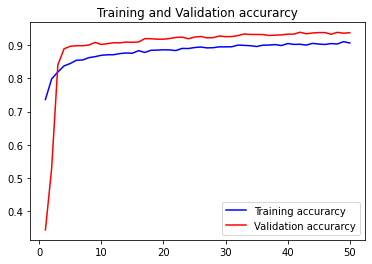

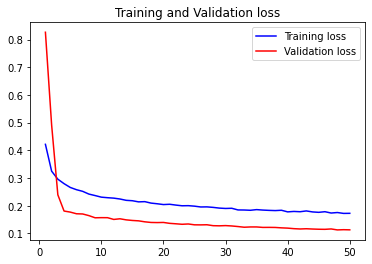

[INFO] Calculating model accuracy
94/94 [==============================] - 1s 7ms/step - loss: 0.1127 - accuracy: 0.9383
Test Accuracy: 93.83333325386047


In [13]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

In [14]:
model.save("5Cnn.h5")